# GP for Options Strategy


In [2]:
import requests as r
from typing import List, Dict, Any, Tuple
from option_history import get_option_chain, get_history
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import mibian
from opstrat.helpers import payoff_calculator
from datetime import datetime
today = datetime.now().strftime("%Y%m%d")


def payoff_calculator(x, op_type, strike, op_pr, tr_type, n):
    y = []
    if op_type == 'c':
        for i in range(len(x)):
            y.append(max((x[i]-strike-op_pr), -op_pr))
    else:
        for i in range(len(x)):
            y.append(max(strike-x[i]-op_pr, -op_pr))
    y = np.array(y)

    if tr_type == 's':
        y = -y
    return y*n


def generate_strategy(
        odf,
        margins_df,
        n_options=5,
        quantities=list(range(1, 11)),
        position_types=[
            'buy',
            'sell'
        ],
        lot_size=50,
):
    test_strategy = []

    for _ in range(np.random.randint(1, n_options+1)):  # no of strike prices
        [strike_price, right, ltp_] = odf[
            ['strike_price', 'right', 'ltp']
        ].sample().values[0]
        pos = np.random.choice(position_types)
        qty = np.random.choice(quantities)
        margin = ltp_ * qty * lot_size
        if pos == 'sell':
            margin = margins_df[
                (margins_df['strike_price'] == strike_price) &
                (margins_df['right'] == right)
            ]['span_margin_required'].values[0] * qty

        test_strategy.append((strike_price, pos, right, qty, ltp_, margin))
        trades_columns = ['strike_price', 'action',
                          'right', 'qty', 'ltp', 'funds_required']

        trades_df = pd.DataFrame(test_strategy, columns=trades_columns)
        trades_df.qty = trades_df.action.map(
            {'buy': 1, 'sell': -1}) * trades_df.qty
        trades_df.funds_required = trades_df.action.map(
            {'buy': 1, 'sell': -1}) * trades_df.funds_required
        trades_df = trades_df.groupby(['strike_price', 'right']).agg({
            'qty': 'sum',
            'ltp': 'mean',
            'funds_required': 'sum',
        }).reset_index()
        trades_df['action'] = trades_df.qty.apply(
            lambda x: 'buy' if x > 0 else 'sell')
        trades_df['qty'] = trades_df.qty.abs()
        trades_df['funds_required'] = trades_df.funds_required.abs()

    return trades_df[trades_columns].to_records(index=False).tolist()


def calculate_margins(odf):
    responses = []

    for row in odf.to_dict('records')[:]:

        resp = r.post(
            'http://localhost:4003/margins',
            json={
                "lists": [{
                    'strike_price': row['strike_price'],
                    'right': row['right'],
                    'expiry_date': row['expiry_date'],
                    'price': row['ltp'],
                    'quantity': 50,
                    "product": "options",
                    'action': 'sell',
                    "stock_code": "NIFTY",
                    "fresh_order_type": "Y",
                }],
                "exchange_code": "NFO",
            },
            headers={
                'content-type': 'application/json',
            }
        ).json()['Success']
        responses.append(resp)

    for row in responses:
        row.update(row['margin_calulation'][0])
        del row['margin_calulation']

    margins_df = pd.DataFrame(responses)
    margins_df[['strike_price', 'span_margin_required']
               ] = margins_df[['strike_price', 'span_margin_required']].astype(float)
    return margins_df


def ltp(df, strike_price, right):
    return df[
        (df['strike_price'] == strike_price) &
        (df['right'] == right)
    ][['ltp', ]].mean(axis=1).round(2).values[0]


def greeks(odf, curr_price, strike_price, days_to_expiry, right):
    volatility = mibian.BS(
        [
            curr_price,
            strike_price,
            0,
            days_to_expiry
        ],
        callPrice=ltp(odf, strike_price, 'Call') if 'call' == right else None,
        putPrice=ltp(odf, strike_price, 'Put') if 'put' == right else None,
    ).impliedVolatility
    option_greeks = mibian.BS(
        [
            curr_price,
            strike_price,
            0,
            days_to_expiry
        ],
        volatility=volatility,
        callPrice=ltp(odf, strike_price, 'Call') if 'call' == right else None,
        putPrice=ltp(odf, strike_price, 'Put') if 'put' == right else None,
    )
    return {
        'delta': option_greeks.callDelta if 'call' == right else option_greeks.putDelta,
        'gamma': option_greeks.gamma,
        'vega': option_greeks.vega,
        'theta': option_greeks.callTheta if 'call' == right else option_greeks.putTheta,
        'rho': option_greeks.callRho if 'call' == right else option_greeks.putRho,
        'volatility': volatility,
    }


def score(spot, row, qvals):
    [q05, q25, q50, q75, q95] = qvals
    _score = 0
    if row['strike_price'] >= spot - q95 and row['strike_price'] <= spot + q95:
        _score += 1
    if row['strike_price'] >= spot - q75 and row['strike_price'] <= spot + q75:
        _score += 1
    if row['strike_price'] >= spot - q50 and row['strike_price'] <= spot + q50:
        _score += 1
    if row['strike_price'] >= spot - q25 and row['strike_price'] <= spot + q25:
        _score += 1
    if row['strike_price'] >= spot - q05 and row['strike_price'] <= spot + q05:
        _score += 1

    return _score/5


def evaluate_strategy(
    strike_range: Tuple[int, int],
    strategies: List[Tuple[float, str, str, int, float, float]],
):

    nifty_range = range(
        int(strike_range[0]),
        int(strike_range[1])
    )
    y = 0
    trade_records = []
    for strike_price, action, right, qty, ltp_, margin in strategies:

        trade_records.append(
            {
                'strike_price': strike_price,
                'action': action,
                'right': right,
                'qty': qty,
                'ltp': ltp_,
                'funds_required': margin,

            }
        )

        points = payoff_calculator(
            nifty_range,
            right[:1].lower(),
            strike_price,
            ltp_,
            action[:1],
            qty
        )
        y += np.array(
            points
        )

    return pd.DataFrame(
        {
            'strike_price': nifty_range,
            'payoff': y,
        }
    ), pd.DataFrame(trade_records)


def fitness(ind, n_range, spot_price, q_vals):
    payoffs, trades_df = evaluate_strategy(
        n_range,
        ind,
    )

    strategy_cost = trades_df.groupby(['strike_price', 'action'])[
        'funds_required'].max().sum()/1e6
    payoffs['score'] = payoffs.apply(lambda x: score(
        spot_price, x, q_vals), axis=1)
    scoring = payoffs.groupby('score')['payoff'].quantile([.05]).unstack() % 20

    profit_scores = scoring.T.values[0].tolist()

    return profit_scores+[strategy_cost, ]

In [31]:
from glob import glob

dfs = list(map(pd.read_csv, glob('data/2*.csv')))
ndf = pd.concat(list(map(pd.read_csv, glob('data/nifty*.csv'))))
ndf.datetime = pd.to_datetime(ndf.datetime)
ndf.set_index('datetime', inplace=True)
cdf = pd.concat(dfs)

cdf.datetime = pd.to_datetime(cdf.datetime)

chains = {stamp: group for stamp, group in cdf.set_index(
    ['strike_price', 'right', 'datetime']).groupby(['datetime'])}

In [132]:

tick_point = 150
nifty_df = ndf[:tick_point]
ts = nifty_df.index[-1]

odf = chains[(ts),].reset_index()
odf['ltp'] = odf['close']
odf.head()

,strike_price,right,datetime,close,exchange_code,expiry_date,high,low,open,open_interest,product_type,stock_code,volume,ltp
0,21650.0,Call,2024-01-31 11:38:00,175.70,NFO,01-FEB-2024,185.00,173.60,184.20,2054400,Options,NIFTY,226700,175.70
1,21600.0,Call,2024-01-31 11:38:00,206.75,NFO,01-FEB-2024,216.80,205.00,216.25,3734600,Options,NIFTY,218650,206.75
2,22150.0,Call,2024-01-31 11:38:00,19.55,NFO,01-FEB-2024,20.85,19.15,20.70,1462650,Options,NIFTY,199350,19.55
3,22000.0,Call,2024-01-31 11:38:00,41.80,NFO,01-FEB-2024,44.80,41.25,44.65,6771450,Options,NIFTY,443100,41.80
4,21750.0,Put,2024-01-31 11:38:00,143.10,NFO,01-FEB-2024,144.00,136.75,137.35,952950,Options,NIFTY,104700,143.10


In [133]:
window_size = 45

hdf = nifty_df.groupby(
    [
        nifty_df.index.date,
        nifty_df.index.hour,
    ]
).agg(
    {
        'open': 'first',
        'high': 'max',
        'low': 'min',
        'close': 'last',
    }
)

[lower, higher] = (hdf.open - hdf.close).quantile([.05, .95]).values

[q05, q25, q50, q75, q95] = (hdf.high - hdf.low).quantile(
    [.05, 0.25, 0.5, 0.75, .95]).values

curr_price = nifty_df.close.iloc[-1]
std_ = nifty_df[-window_size:].close.std()

range_factor = 3

lower_range = int(curr_price - range_factor*std_)
upper_range = int(curr_price + range_factor*std_)

odf = odf[
    (odf['strike_price'] >= lower_range) &
    (odf['strike_price'] <= upper_range)
].reset_index(drop=True)

margins_df = calculate_margins(odf)

print([q05, q25, q50, q75, q95, lower, higher, curr_price])

odf

[72.90999999999985, 93.54999999999927, 119.34999999999854, 128.97499999999854, 136.67499999999853, -91.02999999999993, -50.44000000000124, 21697.75]


,strike_price,right,datetime,close,exchange_code,expiry_date,high,low,open,open_interest,product_type,stock_code,volume,ltp
0,21650.0,Call,2024-01-31 11:38:00,175.70,NFO,01-FEB-2024,185.00,173.60,184.20,2054400,Options,NIFTY,226700,175.70
1,21750.0,Put,2024-01-31 11:38:00,143.10,NFO,01-FEB-2024,144.00,136.75,137.35,952950,Options,NIFTY,104700,143.10
2,21700.0,Call,2024-01-31 11:38:00,147.00,NFO,01-FEB-2024,155.55,145.50,154.75,6179850,Options,NIFTY,548700,147.00
3,21650.0,Put,2024-01-31 11:38:00,96.45,NFO,01-FEB-2024,97.10,92.00,92.40,2374150,Options,NIFTY,184100,96.45
4,21750.0,Call,2024-01-31 11:38:00,122.00,NFO,01-FEB-2024,129.65,120.60,128.95,2608600,Options,NIFTY,240950,122.00
5,21700.0,Put,2024-01-31 11:38:00,118.15,NFO,01-FEB-2024,118.90,112.85,113.45,3380300,Options,NIFTY,358200,118.15


  0%|          | 0/1000 [00:00<?, ?it/s]

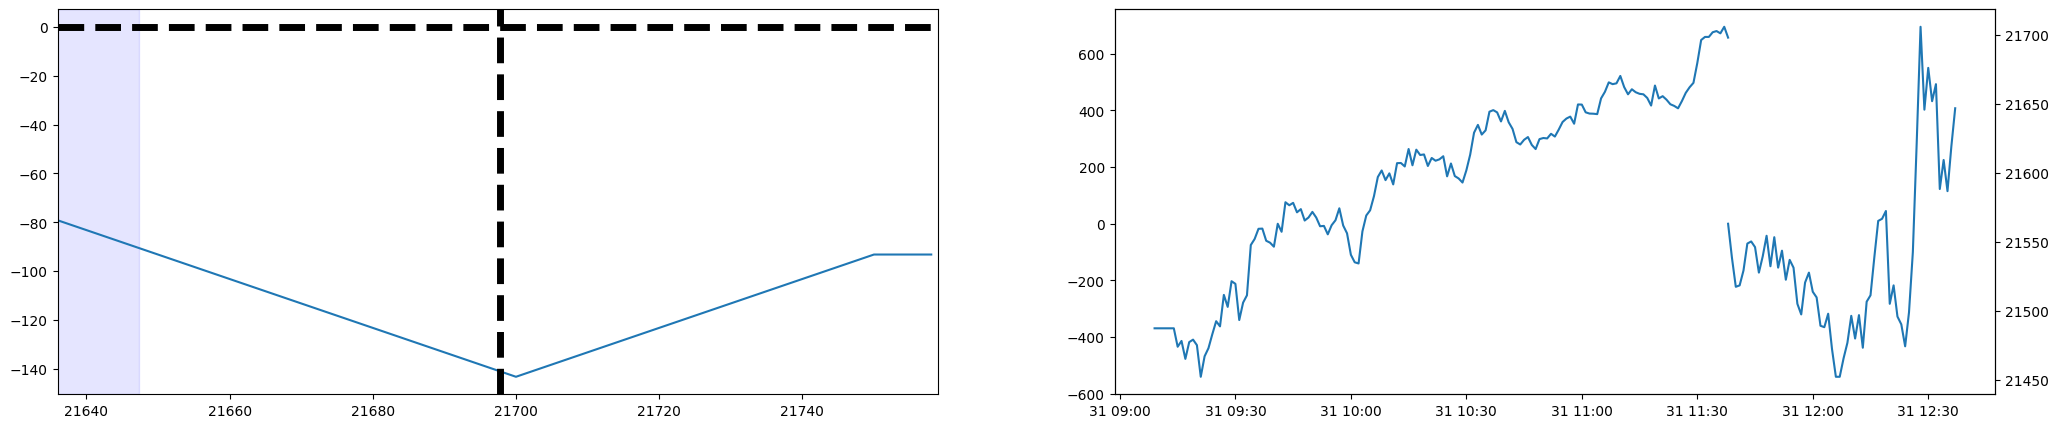

,strike_price,action,right,qty,ltp,funds_required
0,21700.0,buy,Call,1,147.00,7350.00
1,21700.0,buy,Put,1,118.15,5907.50
2,21750.0,sell,Call,1,122.00,128310.39


In [139]:
from tqdm.notebook import trange


def evaluate_trade(row):
    if row['action'] == 'buy':
        return row['qty'] * (row['close'] - row['ltp'])
    else:
        return row['qty'] * (row['ltp'] - row['close'])


strategies = [
    generate_strategy(
        odf=odf,
        margins_df=margins_df,
        n_options=5,
        quantities=list(range(1, 2)),
        position_types=['buy', 'sell']
    )for _ in trange(1000)
]
scores = list(
    map(
        lambda strat: fitness(
            strat,
            (lower_range, upper_range),
            curr_price,
            [q05, q25, q50, q75, q95]),
        strategies
    )
)

scores_df = pd.DataFrame(scores)
scores_df.columns = [f's{i}' for i in scores_df.columns][:-1] + ['cost']
df_cols = scores_df.columns.tolist()
sort_cols = [False] * (len(scores_df.columns)-1) + [True]
# scores_df
sdf = scores_df.sort_values(df_cols, ascending=sort_cols)

strategy = strategies[sdf.index[0]]
payoffs, trades_df = evaluate_strategy(
    (lower_range, upper_range),
    strategy,
)
payoffs['score'] = payoffs.apply(lambda x: score(
    curr_price, x, [q05, q25, q50, q75, q95]), axis=1)


fig, (ax, pnl_ax) = plt.subplots(1, 2, figsize=(25, 5))

vis_range = 3
ax.plot(payoffs.strike_price, payoffs.payoff)
ax.axvline(curr_price, color='k', linestyle='--', lw=5)

ax.axvline(curr_price+q05, color='b', linestyle='--', alpha=.95)
ax.axvline(curr_price-q05, color='b', linestyle='--', alpha=.95)

ax.axvline(curr_price+q25, color='g', linestyle='--', alpha=.75)
ax.axvline(curr_price-q25, color='g', linestyle='--', alpha=.75)

ax.axvline(curr_price+q50, color='y', linestyle='--', alpha=.5)
ax.axvline(curr_price-q50, color='y', linestyle='--', alpha=.5)

ax.axvline(curr_price+q75, color='r', linestyle='--', alpha=.25)
ax.axvline(curr_price-q75, color='r', linestyle='--', alpha=.25)

ax.axvline(curr_price+q95, color='m', linestyle='--', alpha=.1)
ax.axvline(curr_price-q95, color='m', linestyle='--', alpha=.1)

ax.axvspan(curr_price+lower, curr_price + higher, alpha=0.1, color='b')
# ax.axvspan(curr_price+lower, curr_price + higher, alpha=0.1, color='b')
ax.axvline(curr_price+vis_range*lower, color='k', linestyle='--')
ax.axvline(curr_price+vis_range*higher, color='k', linestyle='--')
ax.axhline(0, color='k', linestyle='--', lw=5)

ax.set_xlim(lower_range, upper_range)


test_time_range = 60

ctime = nifty_df[-1:].index
test_time_range = list(
    filter(
        lambda x: x[0] >= ctime,
        chains.keys()
    )
)[:test_time_range]
pnl_data = []

for test_point in test_time_range:
    cdf = chains[test_point].reset_index()
    tdf = trades_df.merge(cdf, on=['strike_price', 'right'])
    tdf = tdf[['action', 'strike_price', 'right', 'qty', 'ltp', 'close']]
    tdf['PnL'] = tdf.apply(evaluate_trade, axis=1) * 50
    pnl_data.append(tdf.PnL.sum())


pnl_ax.plot(test_time_range, pnl_data)
pnl_ax.twinx().plot(nifty_df.close)
plt.show()


trades_df

In [140]:


test_point = list(chains.keys())[tick_point]

cdf = chains[test_point].reset_index()

tdf = trades_df.merge(cdf, on=['strike_price', 'right'])
tdf = tdf[['action', 'strike_price', 'right', 'qty', 'ltp', 'close']]


def evaluate_trade(row):
    if row['action'] == 'buy':
        return row['qty'] * (row['close'] - row['ltp'])
    else:
        return row['qty'] * (row['ltp'] - row['close'])


tdf['PnL'] = tdf.apply(evaluate_trade, axis=1) * 50
tdf.PnL.sum()

# cdf[cdf['strike_price'].isin(trades_df.strike_price.tolist())]

-82.500000000001

In [144]:
def mutate(ind,):

    return ind


mutate(strategies[0])

[(21650.0, 'buy', 'Put', 1, 96.45, 4822.5),
 (21700.0, 'sell', 'Put', 1, 118.15, 136403.62),
 (21750.0, 'sell', 'Call', 1, 122.0, 128310.39)]